# Science4Cast
### A Machine Learning Challenge in the Science Of Science

In this notebook you will learn the following:

1. [How to read the data](#reading)
2. [Visualizing the data](#visualizing)
3. [Creating historic training data](#train)
4. [Training a baseline model (incl. features, training)](#baseline)
5. [Computing the metric: Area Under the Curve (AUC) ROC](#metric)
6. [Evaluating Testset for Competition](#testset)
7. [How to submit](#submit)

### Mini-Summary
In the competition you get
- full_dynamic_graph_sparse: a dynamic graph (list of edges and their creation date) until a time t1.
- unconnected_vertex_pairs: a list of 1,000,000 vertex pairs that are unconnected by time t1.

**Your task in the competition** is to predict which edges of unconnected_vertex_pairs will form until a time t2. Specifically, you sort the list of potential edges in unconnected_vertex_pairs from most likely to most unlikely. The result will be computed via the [AUC of the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

<a id='reading'></a>
## 1. How to read the data

First, get the data from the [IARAI cloud](https://cloud.iarai.ac.at/index.php/s/iTx3bXgMdwsngPn). It contains three files:
- **TrainSet2014_3.pkl:** (33 MB) Semantic network until 2014, and list of unconnected vertex-pairs that can be predicted for training the neural network.
- **TrainSet2014_3_solution.pkl**: (0.5 MB) Solution of whether the unconnected vertex pair from 2014 has been connected by 2017.
- **CompetitionSet2017_3.pkl**: (95 MB) Semantic network until 2017, and list of unconnected vertex-pairs that should be predicted for the evaluation.

Afterwards we can read *TrainSet2014_3.pkl* using pickle.

In [1]:
import pickle
import numpy as np

NUM_OF_VERTICES=64719 # number of vertices of the semantic net

data_source='TrainSet2014_3.pkl'
full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start,years_delta = pickle.load( open( data_source, "rb" ) )

print(data_source+' has '+str(len(full_dynamic_graph_sparse))+' edges between a total of '+str(NUM_OF_VERTICES)+ ' vertices.\n\n')
print('The goal is to predict which of '+str(len(unconnected_vertex_pairs))+' unconnectedvertex-pairs\nin unconnected_vertex_pairs will be connected until '+str(year_start+years_delta)+'.')


TrainSet2014_3.pkl has 2278611 edges between a total of 64719 vertices.


The goal is to predict which of 1000000 unconnectedvertex-pairs
in unconnected_vertex_pairs will be connected until 2017.


 - **full_dynamic_graph_sparse:** The entire semantic network until 2014 or 2017. It is a numpy array, each entry describes an edge in the semantic network. Each edge is described by three numbers [v1, v2, t], where the edge is formed at time t between vertices v1 and v2. t is measured in days since the 1.1.1990.

- **unconnected_vertex_pairs:** This is a list of vertex pairs v1,v2 with deg(v1)>=10, deg(v2)>=10, and no edge exists in the year 2014. The question that the neural network needs to solve: Will an edge form? It does not contain all unconnected vertices, but a random subset.


- **year_start:** year_start=2014


- **years_delta:** years_delta=3

In [2]:
import random

random.seed(42)
print('Type of full_dynamic_graph_sparse: ', type(full_dynamic_graph_sparse))
print('\nExample edges:')
for idx in random.sample(range(len(full_dynamic_graph_sparse)), 5):
    print('Edge in semantic Net (edge #'+str(idx)+'): ', full_dynamic_graph_sparse[idx])

Type of full_dynamic_graph_sparse:  <class 'numpy.ndarray'>

Example edges:
Edge in semantic Net (edge #466956):  [35266 36996  7758]
Edge in semantic Net (edge #104902):  [32250 43887  6171]
Edge in semantic Net (edge #1153556):  [32538 47489  8465]
Edge in semantic Net (edge #1027150):  [13238 35059  8387]
Edge in semantic Net (edge #936213):  [ 1298 33622  8311]


The first and second number stand are indices of a vertex, the 3rd number stands for a time stamp (in days since 1.1.1990). 

For example, the first entry, edge #466956 between vertex 35266 and 36996 has been formed 7758 days after the 1.1.1990. Each of the 64719 vertices stand for a concept in AI or machine learning (its meanings are not revealed during the competition). An edge is formed between the concepts when they co-appear in a scientific paper (specifically, in its title or abstracts).

Next let's see *unconnected_vertex_pairs*:

In [3]:
for idx in random.sample(range(len(unconnected_vertex_pairs)), 5):
    print('Unconnected vertex pairs: ', unconnected_vertex_pairs[idx])

Unconnected vertex pairs:  [22768 11701]
Unconnected vertex pairs:  [13374  2149]
Unconnected vertex pairs:  [18646  3268]
Unconnected vertex pairs:  [12087 13432]
Unconnected vertex pairs:  [14672  1739]


The two indices stand for two vertices. Those two vertices have both a degree larger than 10, but are not connected. The question is whether these concept pairs, for instance (79, 184), will be connected 3 years later. 

<a id='visualizing'></a>
## 2. Visualizing the data

We can use [NetworkX](https://networkx.org/) for visualizing the semantic network at a given time (for further convinience, we translate the numpy list to a sparse array using [SciPy](https://www.scipy.org/)). Let's chose 100 random vertices and see how they look in 2005, 2008, 2011, 2014 and 2017.

First let's create a subgraph from the semantic network with only 100 randomly chosen vertices:

In [4]:
from scipy import sparse
import networkx as nx

rnd_vertices=random.sample(range(100),50) # we use 50 random concepts

full_idx0=[]
full_idx1=[]
for ii in range(len(rnd_vertices)): # here we will find all indices of edges where the concept is either the first or the second vertex
    full_idx0=np.concatenate((full_idx0, np.where(full_dynamic_graph_sparse[:,0] == rnd_vertices[ii])[0]))
    full_idx1=np.concatenate((full_idx1, np.where(full_dynamic_graph_sparse[:,1] == rnd_vertices[ii])[0]))

all_idx=list(set(full_idx0) & set(full_idx1))

subgraph_of_semnet=full_dynamic_graph_sparse[np.array(all_idx).astype(int)] # get the corresponding edge

# These vertices have degree(v)>0, i.e. have at least one edge in the subgraph:
rnd_vertices=list(set(list(subgraph_of_semnet[:,0])+list(subgraph_of_semnet[:,1])))
print('Number of edges in the subgraph: ', len(subgraph_of_semnet))
print('Number of non-zero degree vertices in the subgraph: ', len(rnd_vertices))

print('For easier plotting, change names of vertices, from 0 to ', len(rnd_vertices))

print('5 edges of previous list:')
print(subgraph_of_semnet[0:5])
print('\n\n')

for ii in range(len(rnd_vertices)):
    subgraph_of_semnet[:,0]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,0]]
    subgraph_of_semnet[:,1]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,1]]

print('5 edges of new list:')
print(subgraph_of_semnet[0:5])


Number of edges in the subgraph:  288
Number of non-zero degree vertices in the subgraph:  43
For easier plotting, change names of vertices, from 0 to  43
5 edges of previous list:
[[  54   54 9067]
 [  54   54 8050]
 [  11   23 7732]
 [  11   75 8683]
 [   4   24 9114]]



5 edges of new list:
[[  24   24 9067]
 [  24   24 8050]
 [   4   10 7732]
 [   4   30 8683]
 [   2   11 9114]]


Next, let's create the subgraph at different times.

In [5]:
from datetime import date
day_origin = date(1990,1,1)
years=[2012,2013,2014]

all_nx_nets=[]

for yy in years:
    print('Create Graph for ', yy)
    day_curr=date(yy,12,31)
    all_edges_curr=subgraph_of_semnet[subgraph_of_semnet[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(len(rnd_vertices),len(rnd_vertices)))
    print('Number of edges: ',adj_mat_sparse_curr.getnnz())
    G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')
    
    all_nx_nets.append(G_curr)


Create Graph for  2012
Number of edges:  62
Create Graph for  2013
Number of edges:  92
Create Graph for  2014
Number of edges:  141


Network of the year  2014


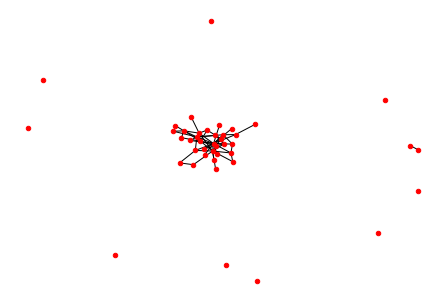

Network of the year  2013


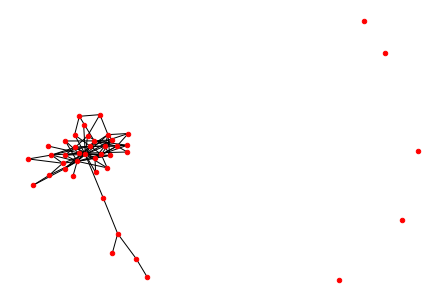

Network of the year  2012


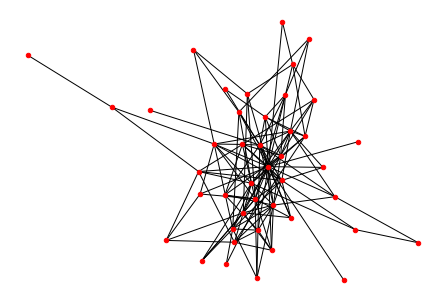

In [15]:
import matplotlib.pyplot as plt

for idx in range(len(all_nx_nets)):
    print('Network of the year ',years[idx])
    curr_net=all_nx_nets[idx]
    nx.draw(curr_net, pos=nx.spring_layout(curr_net), node_size=20)
    plt.show()

<a id='train'></a>
## 3. Creating historic training data

Next, we create training data for the baseline model. The baseline model uses historic states of the neural network, to predict whether unconnected vertices will be connected.

For the validation run, we use the semantic net from 2014 to predict 2017. Therefore, we create training data from 2011 -> 2014. After the training we then can predict 2017.

In [7]:
import time

def create_training_data(full_graph,year_start,years_delta,edges_used=500000,vertex_degree_cutoff=10):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """

    years=[year_start,year_start+years_delta]    
    day_origin = date(1990,1,1)

    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    for yy in years:
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)
        all_edge_lists.append(all_edges_curr)

        print('    Done: Create Graph for ', yy)
        print('    num of edges: ', G_curr.number_of_edges())

    all_degs=np.array(all_sparse[0].sum(0))[0]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

    unconnected_vertex_pairs=[]
    unconnected_vertex_pairs_solution=[]

    time_start=time.time()
    while len(unconnected_vertex_pairs)<edges_used:        
        v1,v2=random.sample(range(len(vertex_large_degs)), 2)

        if v1!=v2 and not all_G[0].has_edge(v1,v2):
            if len(unconnected_vertex_pairs)%10**6==0:
                time_end=time.time()
                print('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M')
                time_start=time.time()
            unconnected_vertex_pairs.append((v1,v2))
            unconnected_vertex_pairs_solution.append(all_G[1].has_edge(v1,v2))

        
    print('Number of unconnected vertex pairs for prediction: ', len(unconnected_vertex_pairs_solution))
    print('Number of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution))
    print('Ratio of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)/len(unconnected_vertex_pairs_solution))
    
    unconnected_vertex_pairs=np.array(unconnected_vertex_pairs)
    unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))
    all_edge_list=np.array(all_edge_lists[0])
    
    return all_edge_list, unconnected_vertex_pairs, unconnected_vertex_pairs_solution

edges_used=1*10**6 # Best would be to use all vertices, to create more training data. But that takes long and requires huge amount of memory. So here we use a random subset.
vertex_degree_cutoff=10
train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start-years_delta, years_delta, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)

day_origin = date(1990,1,1)
years=[year_start-3,year_start-4,year_start-5]

train_sparse=[]
for yy in years:
    print('    Create Graph for ', yy)
    day_curr=date(yy,12,31)
    train_edges_curr=train_dynamic_graph_sparse[train_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))

    train_sparse.append(adj_mat_sparse_curr)
print('done')

    Create Graph for  2011
    Done: Create Graph for  2011
    num of edges:  567750
    Create Graph for  2014
    Done: Create Graph for  2014
    num of edges:  1843253
    edge progress ( 0.0 sec):  0.0 M/ 1.0 M
Number of unconnected vertex pairs for prediction:  1000000
Number of vertex pairs that will be connected:  329
Ratio of vertex pairs that will be connected:  0.000329
    Create Graph for  2011
    Create Graph for  2010
    Create Graph for  2009
done


<a id='baseline'></a>
## 4. Training a baseline model

Here we train a baseline model. The model uses hand-engineered features of the network, in a similar way as a previous [Semantic Network in Quantum Physics](https://www.pnas.org/content/117/4/1910).

### 4.1 Split data in training and testing
First, we split our data in training and testing.

In [8]:
print('    Shuffle training data...')
train_valid_test_size=[0.9, 0.1, 0.0]
x = [i for i in range(len(train_edges_for_checking))]  # random shuffle input

random.shuffle(x)
train_edges_for_checking = train_edges_for_checking[x]
train_edges_solution = train_edges_solution[x]

print('    Split dataset...')
idx_traintest=int(len(train_edges_for_checking)*train_valid_test_size[0])

data_edges_train=train_edges_for_checking[0:idx_traintest]
solution_train=train_edges_solution[0:idx_traintest]  

data_edges_test=train_edges_for_checking[idx_traintest:]
solution_test=train_edges_solution[idx_traintest:]

print('Training, connected  : ',sum(solution_train==1))
print('Training, unconnected: ',sum(solution_train==0))

    Shuffle training data...
    Split dataset...
Training, connected  :  272
Training, unconnected:  899728


<a id='features'></a>
### 4.2 Creating features
Here we train a baseline model. The model uses hand-engineered features of the network, in a similar way as a previous [Semantic Network in Quantum Physics](https://www.pnas.org/content/117/4/1910).

Specifically, it uses 15 features for a vertex pair (v1,v2),

**Features:**
- degree of v1 and v2 in the current year (in validation 2011) and previous two years. (These are six properties)
- number of shared neighbors in total of v1 and v2 in the current year (in validation 2011) and previous two years. (These are six properties)
- number of shared neighbors between v1 and v2 in the current year (in validation 2011) and previous two years. (These are 3 properties)

We only use about 1% of the unconnected examples for training, as computing features is expensive, and the two classes (connected vs unconnected) are very unevenly distributed.

In [9]:
def compute_all_properties(all_sparse,AA02,AA12,AA22,all_degs0,all_degs1,all_degs2,all_degs02,all_degs12,all_degs22,v1,v2):
    """
    Computes hand-crafted properties for one vertex in vlist
    """
    all_properties=[]

    all_properties.append(all_degs0[v1]) # 0
    all_properties.append(all_degs0[v2]) # 1
    all_properties.append(all_degs1[v1]) # 2
    all_properties.append(all_degs1[v2]) # 3
    all_properties.append(all_degs2[v1]) # 4
    all_properties.append(all_degs2[v2]) # 5
    all_properties.append(all_degs02[v1]) # 6
    all_properties.append(all_degs02[v2]) # 7
    all_properties.append(all_degs12[v1]) # 8
    all_properties.append(all_degs12[v2]) # 9
    all_properties.append(all_degs22[v1]) # 10
    all_properties.append(all_degs22[v2]) # 11

    all_properties.append(AA02[v1,v2]) # 12
    all_properties.append(AA12[v1,v2]) # 13
    all_properties.append(AA22[v1,v2]) # 14    

    return all_properties



def compute_all_properties_of_list(all_sparse,vlist):
    """
    Computes hand-crafted properties for all vertices in vlist
    """
    time_start=time.time()
    AA02=all_sparse[0]**2
    AA02=AA02/AA02.max()
    AA12=all_sparse[1]**2
    AA12=AA12/AA12.max()
    AA22=all_sparse[2]**2
    AA22=AA02/AA22.max()
    
    all_degs0=np.array(all_sparse[0].sum(0))[0]
    if np.max(all_degs0)>0:
        all_degs0=all_degs0/np.max(all_degs0)
        
    all_degs1=np.array(all_sparse[1].sum(0))[0]
    if np.max(all_degs1)>0:
        all_degs1=all_degs1/np.max(all_degs1)
    
    all_degs2=np.array(all_sparse[2].sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs2=all_degs2/np.max(all_degs2)

    all_degs02=np.array(AA02[0].sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs02=all_degs02/np.max(all_degs02)
        
    all_degs12=np.array(AA12[1].sum(0))[0]
    if np.max(all_degs12)>0:
        all_degs12=all_degs12/np.max(all_degs12)
        
    all_degs22=np.array(AA22[2].sum(0))[0]
    if np.max(all_degs22)>0:
        all_degs22=all_degs22/np.max(all_degs22)
    
    all_properties=[]
    print('    Computed all matrix squares, ready to ruuuumbleeee...')
    for ii in range(len(vlist)):
        vals=compute_all_properties(all_sparse,
                                    AA02,
                                    AA12,
                                    AA22,
                                    all_degs0,
                                    all_degs1,
                                    all_degs2,
                                    all_degs02,
                                    all_degs12,
                                    all_degs22,
                                    vlist[ii][0],
                                    vlist[ii][1])

        all_properties.append(vals)
        if ii%10**5==0:
            print('compute features: (',time.time()-time_start,'sec) ',ii/10**6,'M/',len(vlist)/10**6,'M')
            time_start=time.time()

    return all_properties

# Rather than using all connected and unconnected vertex pairs for training
# (i.e. needing to compute their properties), we reject about 99% of all unconnected
# examples, to have more examples of connected cases in the training. This significantly
# speeds up the computation, at the price of precision.
data_edges_train_smaller=[]
solution_train_smaller=[]
for ii in range(len(data_edges_train)):
    if (solution_train[ii]==0 and random.random()<0.01) or solution_train[ii]==1:
        data_edges_train_smaller.append(data_edges_train[ii])
        solution_train_smaller.append(solution_train[ii])

data_train=compute_all_properties_of_list(train_sparse,data_edges_train_smaller)

data_train0=[]
data_train1=[]
for ii in range(len(data_edges_train_smaller)):
    if solution_train_smaller[ii]==1:
        data_train1.append(data_train[ii])
    else:
        data_train0.append(data_train[ii])

data_test=compute_all_properties_of_list(train_sparse,data_edges_test)
data_test0=[]
data_test1=[]
for ii in range(len(data_edges_test)):
    if solution_test[ii]==1:
        data_test1.append(data_test[ii])
    else:
        data_test0.append(data_test[ii])
print('done')

    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 6.318189382553101 sec)  0.0 M/ 0.009245 M
    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 6.4152512550354 sec)  0.0 M/ 0.1 M
done


<a id='nn'></a>
### 4.2 Training a neural network

Next we train a simple fully connected, three layer neural network to predict whether a vertex-pair will be connected or not.

0 - train:  1.0144258 ; test:  1.0144225
50 - train:  0.69482934 ; test:  0.6948202
100 - train:  0.49994034 ; test:  0.49991703
150 - train:  0.49933976 ; test:  0.49930948
200 - train:  0.49907824 ; test:  0.49904108
250 - train:  0.49883944 ; test:  0.49879545
300 - train:  0.49861455 ; test:  0.49856406
350 - train:  0.49837178 ; test:  0.49831277
400 - train:  0.49811178 ; test:  0.4980452
450 - train:  0.49784887 ; test:  0.49777544
500 - train:  0.4975773 ; test:  0.49749523
550 - train:  0.49730012 ; test:  0.4972102
600 - train:  0.4969851 ; test:  0.49688554
650 - train:  0.4966278 ; test:  0.4965182
700 - train:  0.49623477 ; test:  0.49611437
750 - train:  0.49581277 ; test:  0.4956801
800 - train:  0.495296 ; test:  0.49514753
850 - train:  0.4947431 ; test:  0.4945767
900 - train:  0.49411058 ; test:  0.49392274
950 - train:  0.49333495 ; test:  0.4931201
1000 - train:  0.49236715 ; test:  0.4921136
1050 - train:  0.4912335 ; test:  0.49093866
1100 - train:  0.4897979 ; t

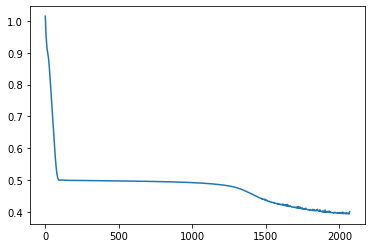

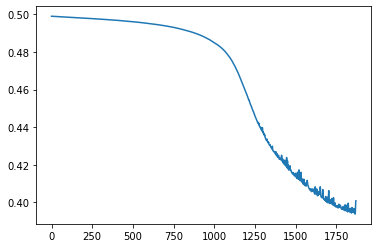

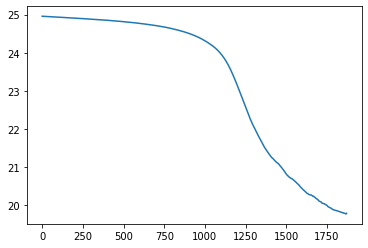

done


In [10]:
import torch
from torch import nn

class ff_network(nn.Module):

    def __init__(self):
        """
        Fully Connected layers
        """
        super(ff_network, self).__init__()

        self.semnet = nn.Sequential( # very small network for tests
            nn.Linear(15, 100), # 15 properties
            nn.ReLU(),
            nn.Linear(100, 100), 
            nn.ReLU(),       
            nn.Linear(100, 10),
            nn.ReLU(),             
            nn.Linear(10, 1)
        )


    def forward(self, x):
        """
        Pass throught network
        """
        res = self.semnet(x)

        return res


def train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size):
    """
    Training the neural network
    """    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    size_of_loss_check=2000
    
    optimizer_predictor = torch.optim.Adam(model_semnet.parameters(), lr=lr_enc)
    
    data_train0=torch.tensor(data_train0, dtype=torch.float).to(device)
    data_test0=torch.tensor(data_test0, dtype=torch.float).to(device)
    
    data_train1=torch.tensor(data_train1, dtype=torch.float).to(device)
    data_test1=torch.tensor(data_test1, dtype=torch.float).to(device)

    test_loss_total=[]
    moving_avg=[]
    criterion = torch.nn.MSELoss()
    
    # There are much more vertex pairs that wont be connected (0) rather than ones
    # that will be connected (1). However, we observed that training with an equally weighted
    # training set (same number of examples for (0) and (1)) results in more stable training.
    # (Imaging we have 1.000.000 nonconnected and 10.000 connected)
    #
    # For that reason, we dont have true 'episodes' (where each example from the training set
    # has been used in the training). Rather, in each of our iteration, we sample batch_size
    # random training examples from data_train0 and from data_train1.
    
    for iteration in range(10000): # should be much larger, with good early stopping criteria
        model_semnet.train()
        data_sets=[data_train0,data_train1]
        total_loss=0
        for idx_dataset in range(len(data_sets)):
            idx = torch.randint(0, len(data_sets[idx_dataset]), (batch_size,))
            data_train_samples = data_sets[idx_dataset][idx]
            calc_properties = model_semnet(data_train_samples)
            curr_pred=torch.tensor([idx_dataset] * batch_size, dtype=torch.float).to(device)
            real_loss = criterion(calc_properties, curr_pred)
            total_loss += torch.clamp(real_loss, min = 0., max = 50000.).double()

        optimizer_predictor.zero_grad()
        total_loss.backward()
        optimizer_predictor.step()

        # Evaluating the current quality.
        with torch.no_grad():
            model_semnet.eval()
            # calculate train set
            eval_datasets=[data_train0,data_train1,data_test0,data_test1]
            all_real_loss=[]
            for idx_dataset in range(len(eval_datasets)):
                eval_datasets[idx_dataset]
                calc_properties = model_semnet(eval_datasets[idx_dataset][0:size_of_loss_check])        
                curr_pred=torch.tensor([idx_dataset%2] * len(eval_datasets[idx_dataset][0:size_of_loss_check]), dtype=torch.float).to(device)
                real_loss = criterion(calc_properties, curr_pred)
                all_real_loss.append(real_loss.detach().cpu().numpy())
             
            test_loss_total.append(np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))

            if iteration%50==0:
                print(str(iteration)+' - train: ',np.mean(all_real_loss[0])+np.mean(all_real_loss[1]),'; test: ',np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))


            if len(test_loss_total)>200: # early stopping
                test_loss_moving_avg=sum(test_loss_total[-50:])
                moving_avg.append(test_loss_moving_avg)
                if len(moving_avg)>10:
                    if moving_avg[-1]>moving_avg[-2] and moving_avg[-1]>moving_avg[-10]:
                        print('Early stopping kicked in')
                        break

    plt.plot(test_loss_total)
    plt.show()
    
    plt.plot(test_loss_total[200:])
    plt.show()    
    
    plt.plot(moving_avg)
    plt.show()

    return True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_semnet = ff_network().to(device)

batch_size=100 # Large batch_size seems to be important
lr_enc=5*10**-4

model_semnet.train()
train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size)  
print('done')

<a id='metric'></a>
## 5. Computing the metric
### Area Under the Curve (AUC) of ROC curve

Now that we have a trained model, we are ready to test the models prediction quality using the metric for the competition: The [Area Under the Curve (AUC) of the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve). We chose this metric as it is less sensitive to noise and independent of the distribution of connected versus unconnected edges.

Additionally, there might be very interesting ways to solve this task, for instance by directly [maximizing the AUC](https://towardsdatascience.com/explicit-auc-maximization-70beef6db14e).

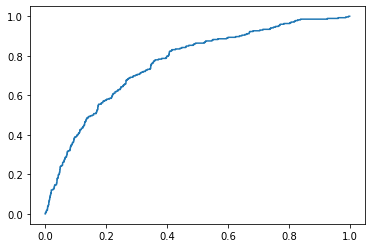

    AUC_train:  0.7640437652827424


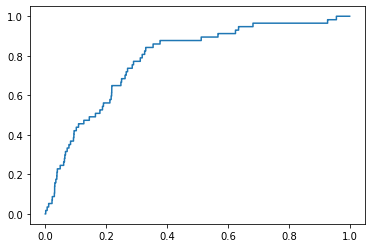

    AUC_test:  0.7852737463868016


In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_ROC(data_vertex_pairs,data_solution):
    data_solution=np.array(data_solution)
    data_vertex_pairs_sorted=data_solution[data_vertex_pairs]
    
    xpos=[0]
    ypos=[0]
    ROC_vals=[]
    for ii in range(len(data_vertex_pairs_sorted)):
        if data_vertex_pairs_sorted[ii]==1:
            xpos.append(xpos[-1])
            ypos.append(ypos[-1]+1)
        if data_vertex_pairs_sorted[ii]==0:
            xpos.append(xpos[-1]+1)
            ypos.append(ypos[-1])      
            ROC_vals.append(ypos[-1])
    
        # # # # # # # # # # # # # # # 
        # 
        # We normalize the ROC curve such that it starts at (0,0) and ends at (1,1).
        # Then our final metric of interest is the Area under that curve.
        # AUC is between [0,1].
        # AUC = 0.5 is acchieved by random predictions
        # AUC = 1.0 stands for perfect prediction.
    
    ROC_vals=np.array(ROC_vals)/max(ypos)
    ypos=np.array(ypos)/max(ypos)
    xpos=np.array(xpos)/max(xpos)
    
    plt.plot(xpos, ypos)
    plt.show()
    
    AUC=sum(ROC_vals)/len(ROC_vals)
    return AUC

data_train=torch.tensor(data_train, dtype=torch.float).to(device)
all_predictions_train=flatten(model_semnet(data_train).detach().cpu().numpy())
sorted_predictions_train=np.flip(np.argsort(all_predictions_train,axis=0))    
AUC_train=calculate_ROC(sorted_predictions_train, solution_train_smaller)
print('    AUC_train: ', AUC_train)

data_test=torch.tensor(data_test, dtype=torch.float).to(device)
all_predictions_test=flatten(model_semnet(data_test).detach().cpu().numpy())
sorted_predictions_test=np.flip(np.argsort(all_predictions_test,axis=0))    
AUC_test=calculate_ROC(sorted_predictions_test, solution_test)
print('    AUC_test: ', AUC_test)

<a id='testset'></a>
## 6. Evaluating Testset for Competition

Next we analyse the testset. If it is for the validation run (2014 network for predicting 2017) or evaluation run (2017 network for predicting 2020), the procedure is the same. Just, in the one case we can compute the AUC, and in the other case we store the final result and submit it to the competition.

In both cases, we compute the 15 features for all unconnected vertex pairs in *unconnected_vertex_pairs*.

In [12]:
# Create properties for evaluation
print('2) Makes predictions for '+str(year_start)+' -> '+str(year_start+3)+' data.')
years=[year_start,year_start-1,year_start-2]

print('2.1) Computes the 15 properties for the '+str(year_start)+' data.')
eval_sparse=[]
for yy in years:
    print('    Create Graph for ', yy)
    day_curr=date(yy,12,31)
    eval_edges_curr=full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix(
                                            (np.ones(len(eval_edges_curr)), (eval_edges_curr[:,0], eval_edges_curr[:,1])),
                                            shape=(NUM_OF_VERTICES,NUM_OF_VERTICES)
                                           )

    eval_sparse.append(adj_mat_sparse_curr)

print('    compute all properties for evaluation')
eval_examples=compute_all_properties_of_list(eval_sparse,unconnected_vertex_pairs)
eval_examples=np.array(eval_examples)

print('2.2) Uses the trained network to predict whether edges are created by '+str(year_start+3)+'.')
eval_examples=torch.tensor(eval_examples, dtype=torch.float).to(device)
all_predictions_eval=flatten(model_semnet(eval_examples).detach().cpu().numpy())

print('3) Creates a sorted index list, from highest predicted vertex pair to least predicted one (sorted_predictions)')
sorted_predictions_eval=np.flip(np.argsort(all_predictions_eval,axis=0))   


2) Makes predictions for 2014 -> 2017 data.
2.1) Computes the 15 properties for the 2014 data.
    Create Graph for  2014
    Create Graph for  2013
    Create Graph for  2012
    compute all properties for evaluation
    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 44.33638954162598 sec)  0.0 M/ 1.0 M
compute features: ( 14.8928701877594 sec)  0.1 M/ 1.0 M
compute features: ( 13.97126030921936 sec)  0.2 M/ 1.0 M
compute features: ( 14.013289213180542 sec)  0.3 M/ 1.0 M
compute features: ( 13.578999996185303 sec)  0.4 M/ 1.0 M
compute features: ( 13.850181579589844 sec)  0.5 M/ 1.0 M
compute features: ( 13.355851888656616 sec)  0.6 M/ 1.0 M
compute features: ( 13.610021352767944 sec)  0.7 M/ 1.0 M
compute features: ( 13.447914600372314 sec)  0.8 M/ 1.0 M
compute features: ( 13.904215574264526 sec)  0.9 M/ 1.0 M
2.2) Uses the trained network to predict whether edges are created by 2017.
3) Creates a sorted index list, from highest predicted vertex pair to le

The variable *sorted_predictions* is the final solution. With it, we can compute again the AUC if we know the solution.

- **For validation:** we can load the solution file and compute the AUC. 
- **For evaluation in competition:** We use json to save the data, and you can then submit via the website.

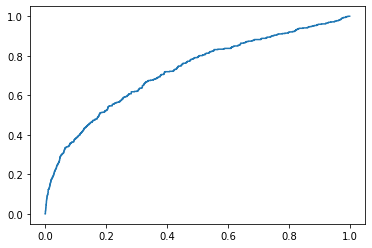

Area Under Curve for Evaluation:  0.7227288142843096 





In [13]:
import json

if year_start==2017:
    # Save the results for submission.
    submit_file="model_all_idx"+str(year_start)+"_"+str(years_delta)+".json"
    all_idx_list_float=list(map(float, sorted_predictions_eval))
    with open(submit_file, "w", encoding="utf8") as json_file:
        json.dump(all_idx_list_float, json_file)
    
    print("Solution stored as "+submit_file+".\nLooking forward to your submission.")        

else:
    with open('TrainSet2014_3_solution.pkl', "rb" ) as pkl_file:
        unconnected_vertex_pairs_solution = pickle.load(pkl_file)
    
    AUC=calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
    print('Area Under Curve for Evaluation: ', AUC,'\n\n\n')

<a id='submit'></a>
## 7. How to submit

Go to the IARAI website of [Science4Cast](https://www.iarai.ac.at/science4cast/) and submit the file created by the code above (*model_all_idx2017_3.json*).

Enjoy -- and have much success, and looking forward to your submission! :)